In [1]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

sys.path.append('../')

from src_experiment import NeuralNet, moon_path, wbc_path, get_moons_data, get_wbc_data, train_model
from geobin import RegionTree, TreeNode

In [2]:
hidden_sizes = [5,4,3]
num_classes = 1
model = NeuralNet(
    input_size = 30,
    hidden_sizes = hidden_sizes,
    num_classes = num_classes,
)


# Data
train_data, test_data = get_wbc_data(label_noise=0.0, batch_size=32)

epochs = 50
save_for_epochs = [0,3,6,9,15,25,35,49]


In [3]:
res, states = train_model(
    model=model,
    train_data = train_data,
    test_data = test_data,
    epochs = epochs,
    # save_everyth_epoch = 20,
    save_for_epochs=save_for_epochs,
    RETURN_STATES=True,
)

Training not saved.


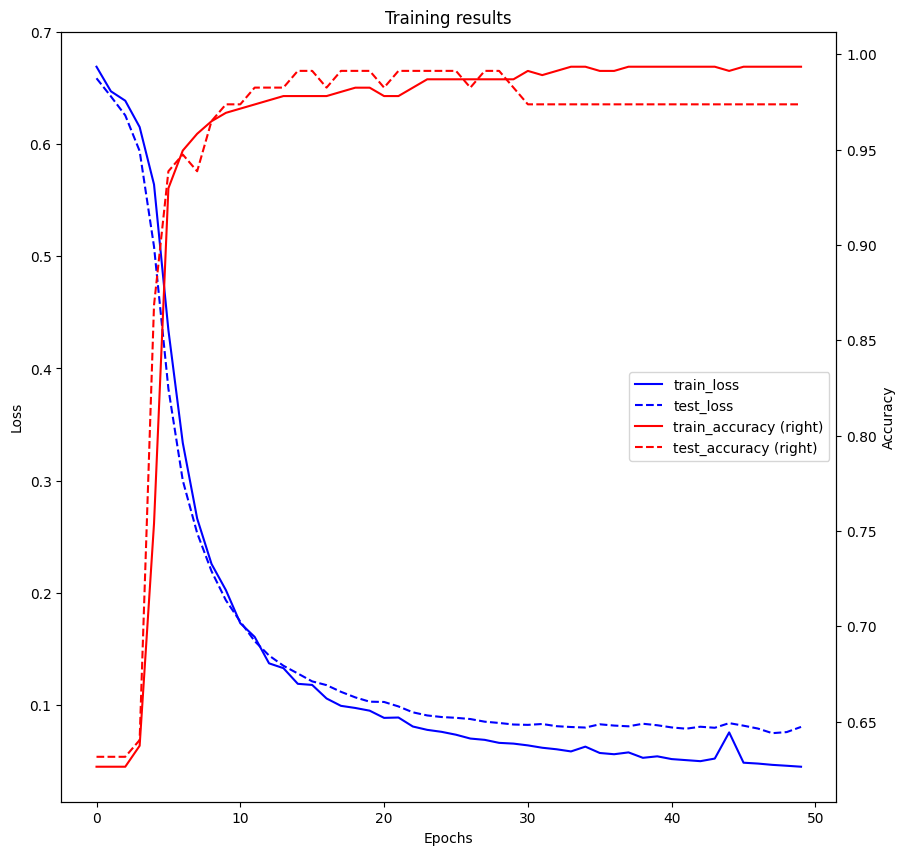

In [4]:
from visualization import plot_training
plot_training(res)

In [5]:
states[0]

OrderedDict([('l1.weight',
              tensor([[ 0.1580,  0.1318,  0.0866,  0.0466, -0.1350, -0.1300, -0.1781,  0.1325,
                       -0.1081,  0.0079, -0.1471, -0.0868,  0.0398,  0.1502, -0.1142,  0.0347,
                        0.1031,  0.1321, -0.0185,  0.1172,  0.0773, -0.0649,  0.0895,  0.0115,
                        0.0839, -0.1125, -0.1819, -0.0812, -0.0204, -0.1303],
                      [-0.0847, -0.0730,  0.0077,  0.1893, -0.1185,  0.1795,  0.0171, -0.0437,
                       -0.0605,  0.0759, -0.1498, -0.0671, -0.0113,  0.1378, -0.0853, -0.0100,
                       -0.1674, -0.1486, -0.0684,  0.1667, -0.0278, -0.0321,  0.1046,  0.0391,
                       -0.0854,  0.1452,  0.0272,  0.0035, -0.1126,  0.0319],
                      [ 0.1676,  0.1105, -0.0706, -0.0513, -0.1240,  0.1668,  0.0406,  0.0178,
                       -0.1091, -0.1180, -0.1281,  0.1659, -0.0951, -0.1368, -0.0172,  0.1597,
                       -0.0287, -0.0506,  0.1818,  0.0381

In [6]:
# import torch
ncounts_per_epoch = {}
total_times = []
building_times = []
passing_times = []
for epoch in [0,49]:
    start = time.time()
    # state_dict = torch.load(states[epoch])
    tree = RegionTree(states[epoch])
    tree.build_tree(verbose=False, check_feasibility=True)
    intermediate = time.time()
    tree.pass_dataloader_through_tree(train_data)
    tree.collect_number_counts()
    ncounts_per_epoch[epoch] = tree.get_number_counts()
    # print(tree.size)
    end = time.time()
    total_time = end-start
    building_time = intermediate-start
    passing_time = end-intermediate
    
    total_times.append(total_time)
    building_times.append(building_time)
    passing_times.append(passing_time)
    print(f"\nEpoch: {epoch}")
    print(f"Total time taken:    {total_time:.3f} s")
    print(f"Time building:       {building_time:.3f} s")
    print(f"Time passing:        {passing_time:.3f} s")
total_time = sum(total_times)




Epoch: 0
Total time taken:    2.096 s
Time building:       2.054 s
Time passing:        0.042 s

Epoch: 49
Total time taken:    2.322 s
Time building:       2.287 s
Time passing:        0.035 s


In [7]:
tree.get_number_counts()

,layer_idx,region_idx,0,1,total
1,1,0,0.0,0.0,0.0
2,2,98,0.0,0.0,0.0
3,3,182,0.0,0.0,0.0
4,4,121,0.0,0.0,0.0
5,1,1,6.0,0.0,6.0
...,...,...,...,...,...
810,3,213,0.0,0.0,0.0
811,4,152,0.0,0.0,0.0
812,4,283,0.0,0.0,0.0
813,3,290,0.0,0.0,0.0


In [8]:
print(total_time)

4.417988538742065


In [9]:
ncounts_per_epoch

{0:      layer_idx  region_idx    1    0  total
 1            1           0  1.0  0.0    1.0
 2            2          70  1.0  0.0    1.0
 3            3         191  1.0  0.0    1.0
 4            4         177  1.0  0.0    1.0
 5            1           1  0.0  0.0    0.0
 ..         ...         ...  ...  ...    ...
 807          4         208  0.0  0.0    0.0
 808          4         349  0.0  0.0    0.0
 809          3         274  0.0  0.0    0.0
 810          4         235  0.0  0.0    0.0
 811          4         401  0.0  0.0    0.0
 
 [811 rows x 5 columns],
 49:      layer_idx  region_idx    0    1  total
 1            1           0  0.0  0.0    0.0
 2            2          98  0.0  0.0    0.0
 3            3         182  0.0  0.0    0.0
 4            4         121  0.0  0.0    0.0
 5            1           1  6.0  0.0    6.0
 ..         ...         ...  ...  ...    ...
 810          3         213  0.0  0.0    0.0
 811          4         152  0.0  0.0    0.0
 812          4      

In [10]:
e0 = ncounts_per_epoch[49]

In [11]:
print(len(e0))
print(len(e0[e0["total"]>0]))

814
149


In [12]:
ncounts_per_epoch[0]["total"].sum()

np.float64(1820.0)

In [13]:
# ncounts_per_epoch[]["total"].sum()


In [14]:
ncounts_per_epoch[49]["total"].sum()


np.float64(1820.0)

In [15]:
from src_experiment import DivergenceEngine, QUANTITIES_TO_ESTIMATE
from typing import Dict, List
class EstimateQuantities1Run:
    """
    Experiment-specific wrapper that:
    - loads number counts
    - loops over epochs
    - delegates all math to DivergenceEngine
    """

    def __init__(
        self,
        ncounts
    ):
        self.ncounts = ncounts

        self.estimates: Dict[str, List[pd.DataFrame]] = {
            q: [] for q in QUANTITIES_TO_ESTIMATE
        }

        # Perform calculations
        self.calculate_estimates()

    # ------------------------------------------------------------------

    def calculate_estimates(self) -> None:
        for epoch, frame in self.ncounts.items():
            engine = DivergenceEngine(frame)
            epoch_results = engine.compute()

            for key, df in epoch_results.items():
                df.insert(0, "epoch", epoch)
                self.estimates[key].append(df)

        # Concatenate epochs
        for key, frames in self.estimates.items():
            self.estimates[key] = (
                pd.concat(frames, ignore_index=True)
                .rename_axis(None, axis=1)
            )

    def get_estimates(self) -> Dict[str, pd.DataFrame]:
        return self.estimates


In [16]:
est1 = EstimateQuantities1Run(ncounts_per_epoch)

/home/johan/Documents/phd/WP1/geometric_binning_estimator/notebooks/../src_experiment/divergence_engine.py:100: RuntimeWarning: invalid value encountered in divide
  logterm = self.m_kw / (self.m_w @ self.m_k)
/home/johan/Documents/phd/WP1/geometric_binning_estimator/notebooks/../src_experiment/divergence_engine.py:107: RuntimeWarning: invalid value encountered in divide
  term = self.m_kw / (self.m_w @ self.m_k)
/home/johan/Documents/phd/WP1/geometric_binning_estimator/notebooks/../src_experiment/divergence_engine.py:117: RuntimeWarning: invalid value encountered in divide
  term = self.m_kw / self.m_w
/home/johan/Documents/phd/WP1/geometric_binning_estimator/notebooks/../src_experiment/divergence_engine.py:100: RuntimeWarning: invalid value encountered in divide
  logterm = self.m_kw / (self.m_w @ self.m_k)
/home/johan/Documents/phd/WP1/geometric_binning_estimator/notebooks/../src_experiment/divergence_engine.py:107: RuntimeWarning: invalid value encountered in divide
  term = self.m

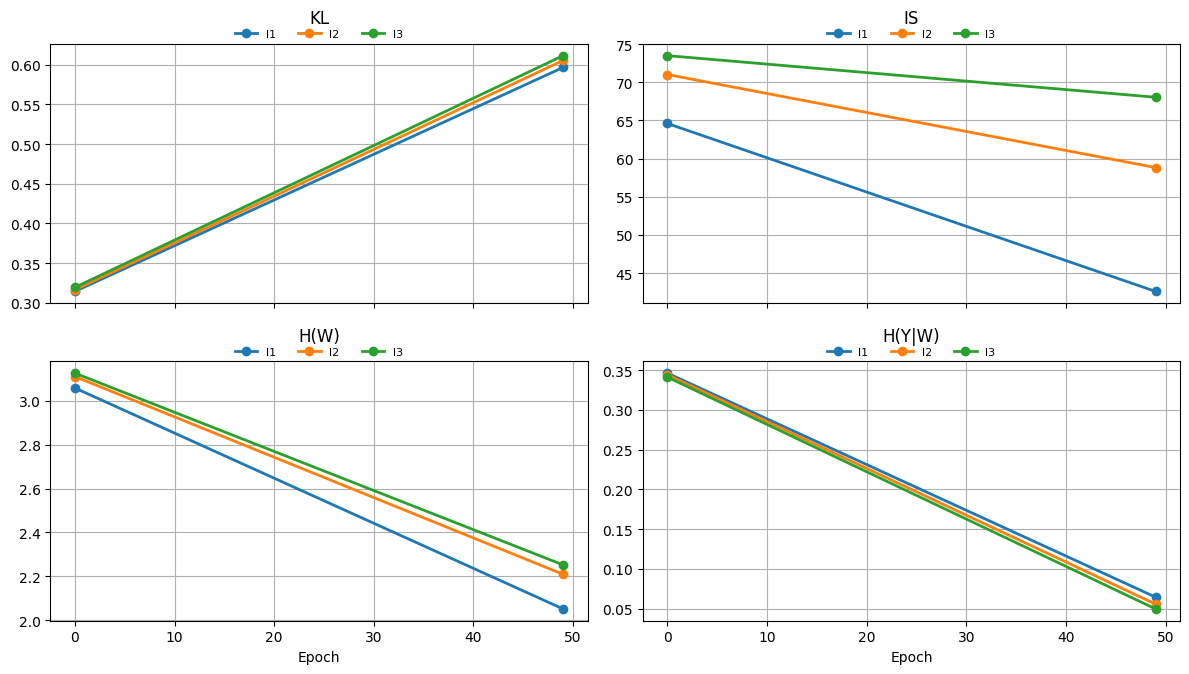

In [17]:
from visualization import plot_all_quantities
plot_all_quantities(est1.get_estimates())